# Automated Driving: Examining the Relationship Between Tesla Adoption and Vehicular Accidents

## Video

Link: https://drive.google.com/file/d/1pFVHLngwOI2jCA4-gBMDcLWhqNrcgyb-/view?usp=sharing

## Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that student names will be included (but PIDs will be scraped from any groups who include their PIDs).

* [X] YES - make available
* [  ] NO - keep private

# Overview

In the past few years, Tesla has emerged as an industry leader in the world of alternative-fuel and autonomous vehicles. Because Teslas' autonomous piloting software might influence driver behavior and vehicle safety, we aim to investigate if  the number of Teslas on the road could be associated with rates of accidents. In this report, we investigate on a state and local level whether the number of Tesla registrations has an impact on preventing high number of accidents in the United States. We found that there was no significant relation on a state-level. However, there was a slight impact on a local-level. 

# Names

- Michael Ji
- Geoffrey Hand
- Carolina Ocanas
- Silvia Vergara

<a id='research_question'></a>
# Research Question

Compared to historical trends of road accidents, does the number of Teslas on the road impact the frequency of road accidents by region in America? In the past five years, does the number of Teslas registered on a state and local level correlate with the frequency of highway accidents associated with vehicle incidents?

<a id='background'></a>

## Background & Prior Work

In the past few years, alternative-fuel and self-driving innovation have propelled Tesla to the forefront of the automobile industry. Although Tesla's vehicles are not fully autonomous, features such as autopilot represent a significant step towards the use of self-driving tech in people's day-to-day commutes. One developing concern for Tesla and its vehicles has been the impact on self-driving technologies on road safety. It is possible that autonomous driving and other safety tech on Teslas can help mitigate accidents. The US Department of Transportation says that autonomous technologies have the potential to react much faster to road conditions than humans can, which improves road safety [1].

However, the safety of Tesla vehicles has also been questioned by research and media. Although autonomous driving can mitigate the risk for some human errors, it is unlikely that software like Testa's autopilot to fully eliminate road accidents. Research done at UC Berkeley [2] point out, as self-driving vehicle technology stands today, that some types of accidents may occur frequently even with the use of fully-autonomous vehicles. In addition, there have been cases where Tesla autopilot software failed to prevent collision fatalities [3]. In summary, there is no conclusive result for the relationship between the adoption of Teslas in different towns or states and the number of road incidents.

References:
 - [1]. *Automated Vehicles for Safety* (https://www.nhtsa.gov/technology-innovation/automated-vehicles-safety)
 - [2]. *Safety Challenges for Autonomous Vehicles in the Absence of Connectivity* (https://www.sciencedirect.com/science/article/pii/S0968090X21001522)
 - [3]. "Tesla Says Autopilot Makes Its Cars Safer. Crash Victims Say It Kills." (https://www.nytimes.com/2021/07/05/business/tesla-autopilot-lawsuits-safety.html)

# Hypothesis


We believe that the number of vehicle accidents will be negatively correlated with number of Teslas on the road, because Teslas' autopilot software would do best in maintained interstate environments. On highways with gradual curvature, edge detection and visual neural networks perform better on dataset-like roads. On the other hand, the number of accidents in general could be positively correlated with the number of Teslas, if people overrely on their car's tech features.

# Dataset(s)

*EV Registrations*

This dataset consists of EV registration from 16 states. Each observation represents one vehicle registration, with a date, vehicle model, state, and either county or zip-code.
- Dataset Name: State EV Registration Data
- Link to the dataset: https://www.atlasevhub.com/materials/state-ev-registration-data/#data
- Number of observations: Varies between states. In total, over 3 million registration entries exist.
- Number of features: Varies between states, but is about 5 for each state's dataset.
- Variables of interest: State, location (zipcode or county), vehicle make and model, registration date.

*US Accidents (updated)*

This dataset contains traffic accident data from 2016 to 2020, using automated APIs to provide incident data. Each observation is one accident, where geolocation/time/weather/description is provided for each.
- Dataset Name: A Countrywide Traffic Accident Dataset (2016 - 2020)
- Link: https://www.kaggle.com/sobhanmoosavi/us-accidents
- Number of observations: 1516064
- Number of features: 47
- Variables of interest: Severity rating, Description (includes interstate number), Zipcode/State, Time

*US Accidents Over 25 Years*

This dataset contains vehicles involved in fatal crashes from 1994 to 2019. It takes into account the type of vehicle and the vehicle's body type.
- Dataset Name: Vehicles Involved in Fatal Crashes by Vehicle Type - State : USA, Year : 2019
- Link: https://www-fars.nhtsa.dot.gov/Vehicles/VehiclesAllVehicles.aspx
- Number of observations: 19,582 (in 2019)
- Number of features: 11
- Variables of interest: Vehicle Body Type, Year, Number of fatalities


*Combining Datasets*

We plan on using the US Accidents Over 25 Years dataset to check if there are long-term trends in vehicle accidents which we need to consider when analyzing the frequency of accidents after the popularity of Teslas. For the other two datasets, we plan on combining using county/state/zipcode, with vehicle accidents and registrations being the other variable columns. 


# Setup

In [197]:
# Import data analysis dependencies
import numpy as np
import pandas as pd

# Import dependencies
# ! pip install -U seaborn
# ! pip install -U matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# EDA
import patsy
import statsmodels.api as sm

# Data Cleaning

**ACCIDENTS**

The US Accidents dataset is fairly clean, with columns in a fairly standard format and with most entries filled. However, we will apply some column transformations and null removal to get it in a 100% usable state.

We first check the number of null values per column. We find some null values, which we will strip from our final dataset later.
We then extract the columns of interest, which include time of accident, location, severity, etc. First, we select the portion of data which we care about:

In [198]:
try:
    accidents_df = pd.read_csv("US_Accidents_Cleaned.csv", index_col=0)
except FileNotFoundError:
    accidents_df = pd.read_csv("US_Accidents_Dec20_updated.csv")

    # Get subset of data: Severity, accident time, Description, county, state, zip-code,
    accidents_geo_df = accidents_df[["Severity", "Start_Time", "Description", "County", "State", "Zipcode", "Sunrise_Sunset"]]

    # Suppress SettingWithCopyWarning
    pd.options.mode.chained_assignment = None  # default='warn'

    # Strip columns with strings
    for variable in ["Description", "County", "State", "Sunrise_Sunset"]: 
        stripped_col = accidents_geo_df[variable].str.strip()
        accidents_geo_df[variable] = stripped_col.values
        
    # Convert zipcodes by truncation
    accidents_geo_df['Zipcode'] = accidents_geo_df['Zipcode'].str[:5]

    # Rename columns
    accidents_geo_time_df = accidents_geo_df.rename(
        columns={"Start_Time": "Datetime", "Sunrise_Sunset": "Time of Day"})

    # Convert data for times to datetime
    accidents_geo_time_df["Datetime"] = pd.to_datetime(accidents_geo_time_df["Datetime"])

    # Create is night column
    accidents_geo_time_df["Night"] = np.where(accidents_geo_time_df['Time of Day'] == 'Night', True, False)

    # Create interstate column
    accidents_geo_time_df['Is_Interstate'] = np.where(accidents_geo_time_df['Description'].str.contains("I-"), True, False)

    # Create US highway column
    accidents_geo_time_df['Is_US_Highway'] = np.where(accidents_geo_time_df['Description'].str.contains("US-"), True, False)

    # Drop NaNs. This operation only drops around 0.1% of the database
    accidents_geo_time_df = accidents_geo_time_df.dropna(axis='rows')

    #To save dataset, run the following:
    #accidents_geo_time_df.to_csv('US_Accidents_Cleaned.csv')

    accidents_df = accidents_geo_time_df

C:\Users\miche\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [199]:
# Print out head of accidents dataset
accidents_df.head()

,Severity,Datetime,Description,County,State,Zipcode,Time of Day,Night,Is_Interstate,Is_US_Highway
0,3,2016-02-08 00:37:08,Between Sawmill Rd/Exit 20 and OH-315/Olentang...,Franklin,OH,43017,Night,True,False,False
1,2,2016-02-08 05:56:20,At OH-4/OH-235/Exit 41 - Accident.,Montgomery,OH,45424,Night,True,False,False
2,2,2016-02-08 06:15:39,At I-71/US-50/Exit 1 - Accident.,Hamilton,OH,45203,Night,True,True,True
3,2,2016-02-08 06:15:39,At I-71/US-50/Exit 1 - Accident.,Hamilton,OH,45202,Night,True,True,True
4,2,2016-02-08 06:51:45,At Dart Ave/Exit 21 - Accident.,Summit,OH,44311,Night,True,False,False


We strip all string-like columns for leading and trailing spaces. Some of the zipcodes contain the "-XXXX" extension subindexing, which we will also remove. We also rename our columns.

In addition, we do datatype conversion, as well as adding new columns. We need to convert the date and time entries to Datetime, and create new columns of booleans to describe whether an accident was a highway accident.

On our processed dataset, we check the number of highway accidents to make sure the observation counts make sense. In addition, we strip null values. We save the cleaned dataset as a CSV.

In the end, we have approximately 1.5 million observations, with state, zip code, time of day, and highway/interstate information extracted.

**TESLA REGISTRATION**

We turn to cleaning our EV registration database, which contains information on Tesla registrations. It turns out that this dataset superset is far less clean than the accidents dataset. We have to standardize the column labels, registration locations, etc. for the data to be usable. There are also a lot more NaN rows.

We also must perform extensive data wrangling to obtain a set of consistent zipcodes.

In [200]:
try:
    registration_df = pd.read_csv("US_EV_Registrations_Cleaned.csv", index_col=0)
except FileNotFoundError:
        # Registration-specific imports
        import time

        # states in dataset (obtained from dataset source)
        states = ['ca', 'co', 'ct', 'fl', 'mt', 'mi', 'mn', 'nj', 'ny', 'or', 'tn', 'tx', 'vt', 'va', 'wa', 'wi']

        # fetches each sub-dataset and appends it to the whole
        reg_df = pd.DataFrame()
        total_start_time = time.time()
        for state in states:
            start_time = time.time()
            try:
                print(f"Fetching {state}")
                url = f"https://www.atlasevhub.com/public/dmv/{state}_ev_registrations_public.csv"
                tmp_state = pd.read_csv(url)
            except Exception as err:
                print(f'\tUnable to fetch {state} from {url}.')
                print(f"\tOperation failed in {round(time.time() - start_time,1)} seconds.")
                print(err)
                continue
            print(f"\tOperation completed in {round(time.time() - start_time,1)} seconds.", end=' ')
            print(f"Found {tmp_state.shape[0]} rows, {tmp_state.shape[1]} columns.")
            
            # label dataset reliably by state
            tmp_state['state_tmp'] = state

            reg_df = pd.concat([reg_df, tmp_state])

        print(f"Total time elapsed: {round(time.time() - total_start_time,1)} seconds")

        # see how sparse our data is
        reg_df.notnull().mean().sort_values() * 100

        # We see that the values we care about most (name and date) are nearly all present, as expected (since they are the primary focus of the source dataset)
        reg_df = reg_df.rename(columns={"Registration Valid Date": "valid_date", "Vehicle Name": "vehicle_name"})

        # check null breakdown by state
        total_state = reg_df.state_tmp.value_counts()
        null_date = reg_df[reg_df['valid_date'].isnull()].state_tmp.value_counts()
        null_name = reg_df[reg_df['vehicle_name'].isnull()].state_tmp.value_counts()
        print((null_date / total_state * 100).dropna())
        print((null_name / total_state * 100).dropna())

        # vehicle_name is substituted with the `Make` and `Model` fields in some datasets

        # concatenates Make and Model for missing values
        # takes ~ 4min
        reg_df['vehicle_name_tmp'] = reg_df.apply(lambda row: row.Make + ' ' + row.Model if pd.isna(row.vehicle_name) else row.vehicle_name, axis=1)

        # checking nulls after change
        total_state = reg_df.state_tmp.value_counts()
        null_date = reg_df[reg_df.valid_date.isnull()].state_tmp.value_counts()
        null_name = reg_df[reg_df.vehicle_name_tmp.isnull()].state_tmp.value_counts()
        print((null_date / total_state * 100).dropna())
        print((null_name / total_state * 100).dropna())

        # turns out `valid_date` isn't reliable
        # the only consistent datelike entry is `DMV Snapshot / DMV Snapshot (Date)`
        # some states reported snapshots differently (provided/received), so it may be in either column

        # handling if one of the fields isn't present anymore
        for field in ['DMV Snapshot', 'DMV Snapshot (Date)']:
            if field not in reg_df.columns:
                reg_df[field] = np.NaN

        total_state = reg_df.state_tmp.value_counts()
        null_date_snap = reg_df[reg_df['DMV Snapshot'].isnull()].state_tmp.value_counts()
        null_date_snap_date = reg_df[reg_df['DMV Snapshot (Date)'].isnull()].state_tmp.value_counts()
        print((null_date_snap / total_state * 100).dropna())
        print((null_date_snap_date / total_state * 100).dropna())

        # these can be merged cleanly since they are not intersecting
        reg_df['snapshot_date'] = reg_df['DMV Snapshot'].fillna(reg_df['DMV Snapshot (Date)'])

        # the dates all wrapped in strings, with parenthesis around the actual date
        reg_df['snapshot_date'] = reg_df.apply(lambda row: row.snapshot_date.split('(')[1].split(')')[0], axis=1)

        # check to see if any null values are still present
        print(reg_df['state_tmp'].isnull().value_counts())
        print(reg_df['vehicle_name_tmp'].isnull().value_counts())
        print(reg_df['snapshot_date'].isnull().value_counts())

        # nearly all columns contain one of these geo-locators
        reg_df = reg_df[reg_df['County GEOID'].notnull() | reg_df['ZIP Code'].notnull() | reg_df['County'].notnull()]

        # remove undefined counties
        reg_df = reg_df[~reg_df['County'].isin(['Other County', 'Unknown County'])]

        # one county was misspelled
        reg_df = reg_df.replace(to_replace='Gadsen', value='Gadsden')

        # drop unknown GEOIDs
        reg_df = reg_df[reg_df['County GEOID'] != 'Unknown']

        # drop non-numeric zip codes
        def can_float(obj) -> bool:
            try:
                float(obj)
                return True
            except:
                return False
        reg_df = reg_df[reg_df['ZIP Code'].apply(can_float)]

        # we need to use this supplemental dataset to translate County GEOIDs and County names to Zip Codes
        # obtained from https://www.kaggle.com/danofer/zipcodes-county-fips-crosswalk
        zip_df = pd.read_csv('ZIP-COUNTY-FIPS_2017-06.csv', converters={'ZIP': '{:0>5}'.format, 'STCOUNTYFP': '{:0>5}'.format})
        zip_df = zip_df.replace(to_replace='Miami-Dade County', value='Dade County')
        fl_df = zip_df[zip_df.STATE == 'FL'].drop_duplicates(['COUNTYNAME'])
        fl_df.COUNTYNAME = fl_df.COUNTYNAME.str.upper()
        fl_df = fl_df.drop(columns=['CLASSFP', 'STCOUNTYFP'])
        fl_df['SEARCHTERM'] = fl_df.COUNTYNAME.str.split().str[0]
        fl_df = fl_df[['ZIP', 'SEARCHTERM']]

        # converting to python dicts saves an incredible amount of time
        fl_dict = fl_df.set_index('SEARCHTERM').to_dict()['ZIP']

        gid_df = zip_df[['ZIP', 'STCOUNTYFP']].drop_duplicates(['STCOUNTYFP'])
        gid_dict = gid_df.set_index('STCOUNTYFP').to_dict()['ZIP']

        def county_to_zip(row) -> str:
            global zip_df
            global fl_dict

            try:
                if pd.notnull(row['ZIP Code']):
                    return f"{int(row['ZIP Code']):0>5}"
                elif pd.notnull(row['County GEOID']):
                    return gid_dict[f"{row['County GEOID']:0>5}"]
                elif pd.notnull(row['County']):
                    county_name = f"{row['County']} County".upper()

                    if county_name == 'OTHER COUNTY' or county_name == 'UNKNOWN COUNTY':
                        return np.NaN
                    elif county_name == 'GADSEN COUNTY':
                        county_name = 'GADSDEN COUNTY'

                    state = row['state_tmp'].upper()

                    search_term = county_name.split()[0]

                    try:
                        result = fl_dict[search_term]
                        return result
                    except:
                        return np.NaN
                
            except:
                print(f"failed on {row.name}")
                return np.NaN

        reg_df['ZIP Code'] = reg_df.apply(county_to_zip, axis=1)
        


        # commit df change and rename some columns
        reg_df = reg_df[['state_tmp', 'vehicle_name_tmp', 'snapshot_date', 'ZIP Code']]
        reg_df.columns = ['State', 'Vehicle_Name', 'Date', 'Zipcode']

        # select only Tesla vehicles
        reg_df = reg_df[reg_df.Vehicle_Name.str.contains('Tesla')]

        # confirm we only have Teslas
        reg_df.Vehicle_Name.str.startswith('Tesla').value_counts()

        # reset index, since old ids aren't relevant
        reg_df = reg_df.reset_index(drop=True)

        # We see the number of Teslas per state registered
        reg_df
        print(reg_df.groupby(['State']).count())

        # looks good, export to csv by uncommenting
        # reg_df.to_csv('US_EV_Registrations_Cleaned.csv')

        registration_df = reg_df

C:\Users\miche\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [201]:
# Print head of registration dataframe
registration_df.head()

,State,Vehicle_Name,Date,Zipcode
0,ca,Tesla Roadster,12/31/2011,95307.0
1,ca,Tesla Roadster,12/31/2011,95307.0
2,ca,Tesla Roadster,12/31/2011,95409.0
3,ca,Tesla Roadster,12/31/2011,95409.0
4,ca,Tesla Roadster,12/31/2011,95409.0


**Accidents Over 25 Years**

Lastly, we import our historical accidents dataset. This dataset is clean and can be imported with a one-liner.

In [202]:
# Read tsv xls file.
historical_crashes_df = pd.read_csv("Fatalities25Years.xls", sep='\t').dropna()

# View head of dataframe
historical_crashes_df.head()

,Year,Fatalities,Resident Population (Thousands),"Fatality Rate per 100,000 Population",Licensed Drivers (Thousands),"Fatality Rate per 100,000 Licensed Drivers",Registered Motor Vehicles (Thousands),"Fatality Rate per 100,000 Registered Vehicles",Vehicle Miles Traveled (Billions),Fatality Rate per 100 Million VMT,Fatal Crashes
1,1994.0,40716.0,260327.0,15.64,175403.0,23.21,192497.0,21.15,2358.0,1.73,36254.0
2,1995.0,41817.0,262803.0,15.91,176628.0,23.68,197065.0,21.22,2423.0,1.73,37241.0
3,1996.0,42065.0,265229.0,15.86,179539.0,23.43,201631.0,20.86,2484.0,1.69,37494.0
4,1997.0,42013.0,267784.0,15.69,182709.0,22.99,203568.0,20.64,2552.0,1.65,37324.0
5,1998.0,41501.0,270248.0,15.36,184861.0,22.45,208076.0,19.95,2628.0,1.58,37107.0


# Data Analysis & Results

# Section 1: EDA

**HISTORICAL DATA**

Before we dive into our Tesla data, we'll use the US Accidents Over 25 Years dataset to get a deeper understanding of historical trends relating to vehicle accidents. This preliminary EDA will give us preceding context for the rest of our analysis. We first visualize the number of vehicle crashes in the past 25 years:

[(0.0, 50000.0)]

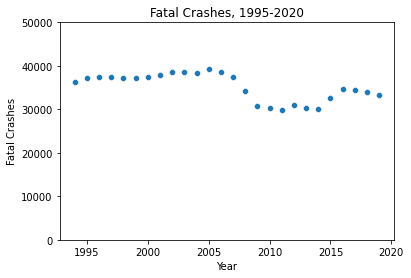

In [203]:
# Visualize fatal crashes over 25 years
fig, ax = plt.subplots()
sns.scatterplot(x="Year", y = "Fatal Crashes", data=historical_crashes_df).set(title="Fatal Crashes, 1995-2020")
ax.set(ylim=(0, 50000))

It seems that the number of fatal crashes dipped between 2008 and 2015. However, the number of crashes in the past few years seem to be somewhat stable. This means that there are probably no outsized effects which would greatly impact our Tesla analysis, which looks at road accidents past 2015. We can also take a look at fatality rates adjusted for vehicle miles over the past 25 years:

[Text(0.5, 1.0, 'Fatality Rates, 1995-2020')]

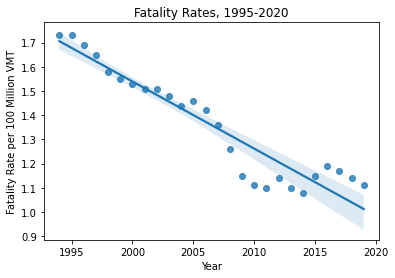

In [204]:
# Generate scatterplot with fit for fatality rates over time
sns.regplot(x="Year", y = "Fatality Rate per 100 Million VMT", data=historical_crashes_df).set(title="Fatality Rates, 1995-2020")

As you can see, there is a steady drop in vehicle fatality rates over the past 25 years. We suspect that this has to do with improved safety technology on cars, which can allow drivers to avoid or be less harmed in the event of a crash. Since Tesla vehicles are equipped with advanced driving assists and sensors, we may see such an effect drive a negative association between Tesla adoption and accidents.

**TESLA DATA EDA**

Now that we have a basic idea of historical trends in motor accidents, we'll explore our data for Tesla registrations. First, let's see who buys the most Teslas.

[Text(0.5, 1.0, 'Tesla Registrations By State')]

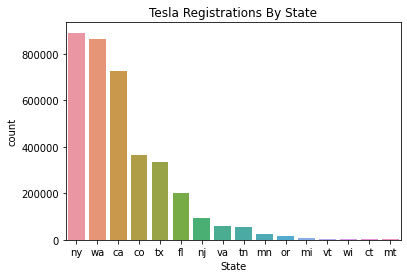

In [205]:
# First, let's see which states buy the most Teslas (or register them the most)
sns.countplot(x="State", data =registration_df, order=registration_df["State"].value_counts().index).set(title="Tesla Registrations By State")

On a zip code level, we'll examine the distribution of Teslas per zip code:

Statistics for zip codes for Tesla vehicle registrations:
count      6872.000000
mean        531.130821
std        3383.589683
min           1.000000
25%           6.000000
50%          32.000000
75%         209.250000
max      174830.000000
Name: Zipcode, dtype: float64



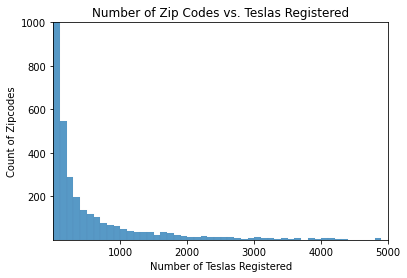

In [206]:
print("Statistics for zip codes for Tesla vehicle registrations:")
print(registration_df["Zipcode"].value_counts().describe())
sns.histplot(registration_df["Zipcode"].value_counts(), binwidth=100).set(title="Number of Zip Codes vs. Teslas Registered")
plt.ylim(1, 1000)
plt.xlim(1, 5000)
plt.xlabel("Number of Teslas Registered")
plt.ylabel("Count of Zipcodes")
print()

By state, we expect the large, coastal, urbanized states such as New York, California, and Washington to have more Teslas on the road. By zipcode, we see that the average number of Teslas registered per zip code is about 531, but there is an extreme outlier (174830) for one zip code (90032). Upon further inspection, this zip code corresponds to downtown Los Angeles, which makes sense. There are some other outlier zip codes which correspond to major cities. In general, number of zip codes vs. Teslas registered follows an inverse exponential distribution, where most zip codes have a few registered Teslas, and zip codes with more Teslas are rarer.

We now plot the number of accidents as a distribution:

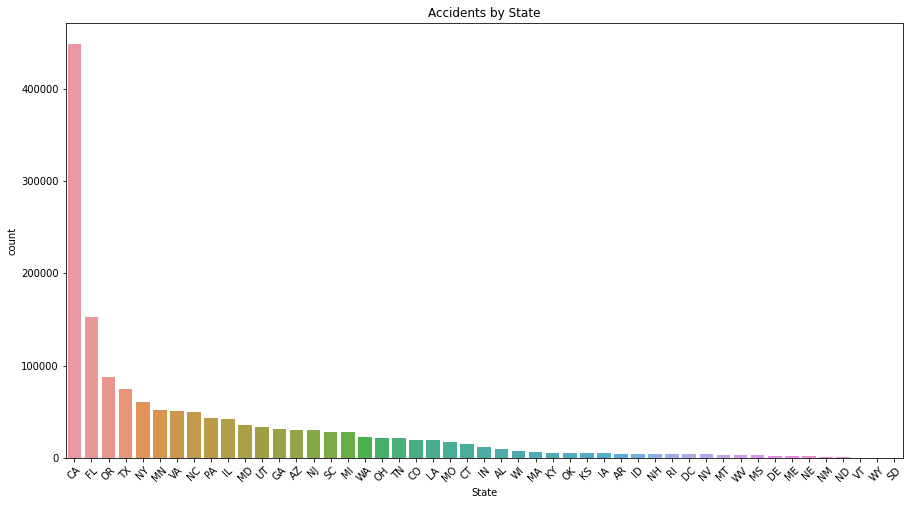

In [207]:
# Plot large figure
plt.figure(figsize = (15,8))

# Get plot of histogram
sns.countplot(x="State", data=accidents_df, order=accidents_df["State"].value_counts().index).set(title="Accidents by State")

# Rotate labels
plt.xticks(rotation=45)
print()

Statistics for zip codes for accidents:
count    19400.000000
mean        78.095155
std        185.167821
min          1.000000
25%          4.000000
50%         14.000000
75%         63.000000
max       3660.000000
Name: Zipcode, dtype: float64



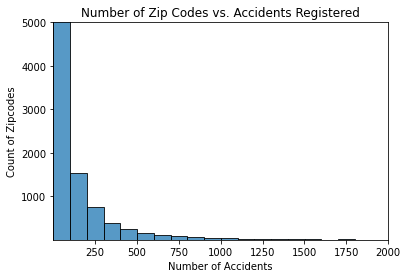

In [208]:
print("Statistics for zip codes for accidents:")
print(accidents_df["Zipcode"].value_counts().describe())
sns.histplot(accidents_df["Zipcode"].value_counts(), binwidth=100).set(title="Number of Zip Codes vs. Accidents Registered")
plt.ylim(1, 5000)
plt.xlim(1, 2000)
plt.xlabel("Number of Accidents")
plt.ylabel("Count of Zipcodes")
print()

By state, it seems that California leads in number of vehicle accidents. Note that Washington and New York (along with other states) have much fewer counts of accidents, probably due to their lower population. By zip code, we see an average of 78 accidents recorded per zip code, with some zip codes having a few thousand recorded accidents. As indicated by the quartiles, most zip codes have only a few accidents on record.

The distribution of accidents on both a state level and zip-code level appear to follow an inverse or exponential distribution, similar to the distribution of Teslas versus location. Many locations have a few accidents, while a small amount of locations have many accidents.

We now do some datetime visualization:

In [209]:
def reg_to_month_year(s: str):
    try:
        _, month, year = s.split("/")
    except:
        return np.NaN
    if len(month) == 1:
        month = "0" + month

    return month + "/" + "01/" + year
    # return "-".join([year, "01", month])

def acc_to_month_year(s: str):
    try:
        date, _ = s.split(" ")
    except:
        return np.NaN
    try:
        year, month, _ = date.split("-")
    except:
        return np.NaN
    if len(month) == 1:
        month = "0" + month

    return month + "/" + "01/" + year
    # return "-".join([year, "01", month, ])

def split_month_year(s: str):
    month, year = s.split("/")
    return month, year

In [210]:
accidents_df["Datetime"] = accidents_df.Datetime.apply(acc_to_month_year)
accidents_df = accidents_df.dropna()
accidents_df = accidents_df.rename(columns={"Datetime": "Date"})

registration_df["Date"] = registration_df.Date.apply(reg_to_month_year)
registration_df = registration_df.dropna()
registration_df.State = registration_df.State.str.upper()


In [211]:
grouped_accs = accidents_df.groupby(by=["State", "Date"]).count().iloc[:, 0]
grouped_regs = registration_df.groupby(by=["State", "Date"]).count().iloc[:, 0]

grouped_accs = grouped_accs.reset_index([0,1])
grouped_regs = grouped_regs.reset_index([0,1])

grouped_accs.columns = ["State", "Date", "Count"]
grouped_regs.columns = ["State", "Date", "Count"]

We have created a grouped accident and grouped registration dataset (grouped by state) with dates attached. 

Now, let's visualize state accidents over time, and number of registrations over time, for each state in our registration dataset.

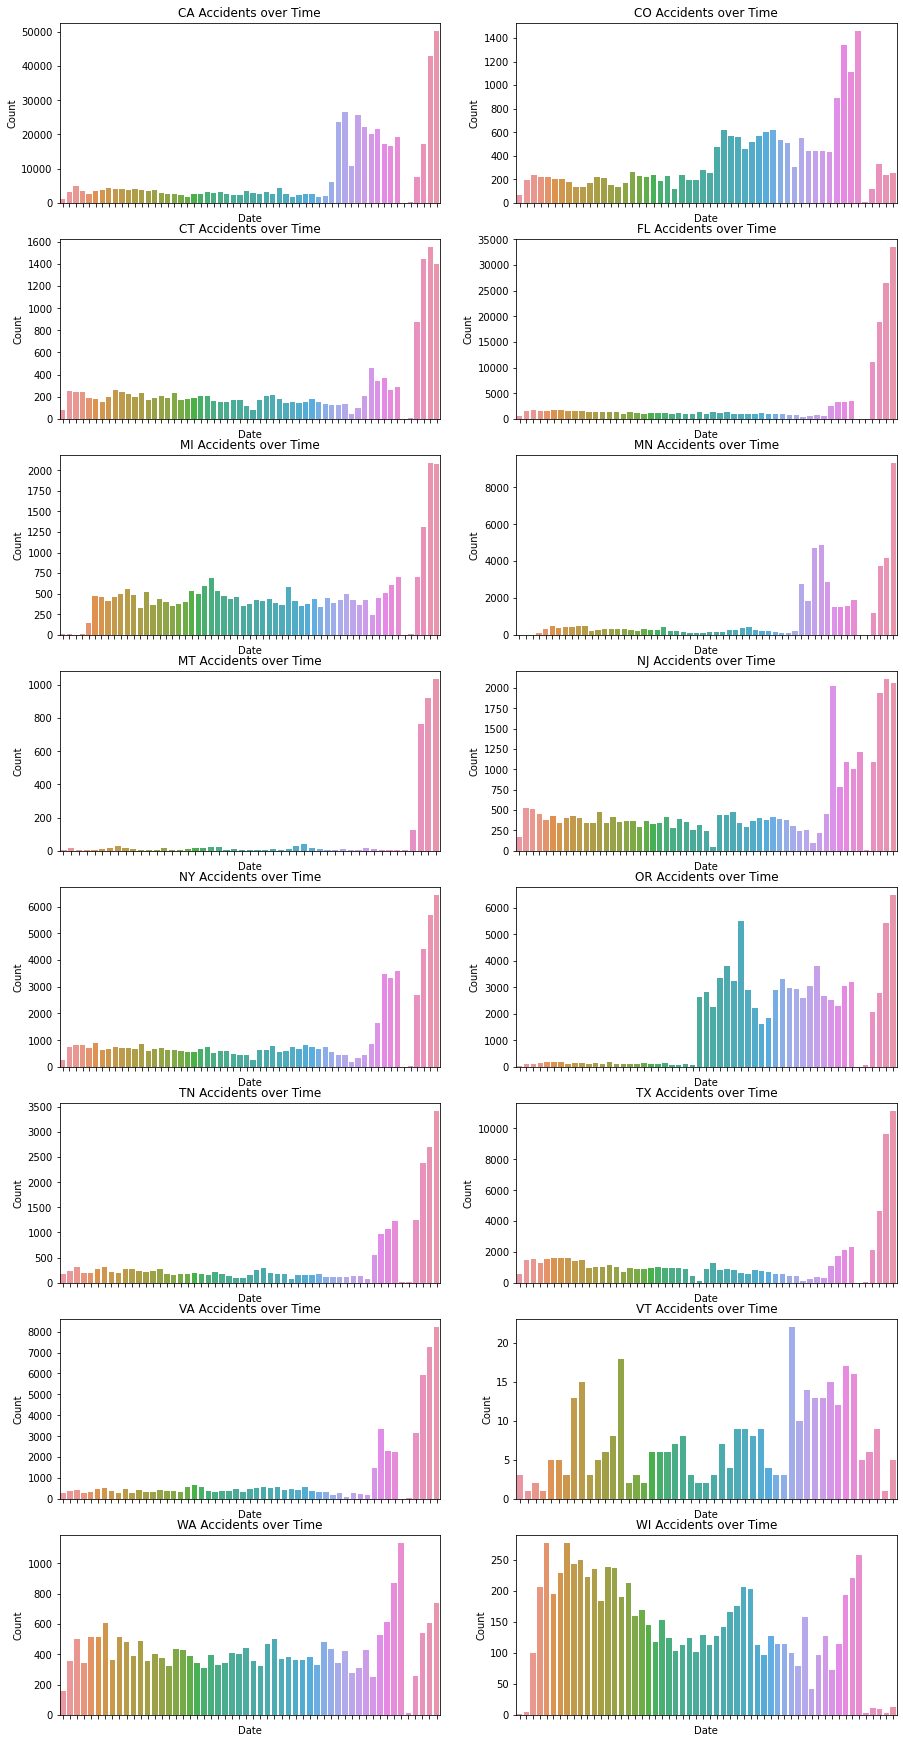

In [212]:
# Suppress SettingWithCopyWarning
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# We plot, by state, accidents over time
fig, axes = plt.subplots(8, 2, figsize=(15, 20))
plt.subplots_adjust(top=1.3)

for n, state in enumerate(grouped_regs["State"].unique()):
    state_accs = grouped_accs[grouped_accs["State"] == state]
    state_accs["Datetime"] = pd.to_datetime(state_accs["Date"])
    state_accs = state_accs.sort_values(by="Datetime")
    sns.barplot(data=state_accs, x="Date", y="Count", ax=axes[int(n / 2), int(n % 2)]).set(xticklabels=[], title=str(state) + " Accidents over Time")


In some states (such as CA and VA), accident rates stay even in a uniform distribution, before some outsized influence appears after in 2019. We suspect that new data was added to the accident observations after 2019.

For other states, such as VT and WI, there is high variability in number of accidents over time. This is probably due to the relatively low population of those states, leading to more variability.

For Tesla registrations over time, let's look at California.

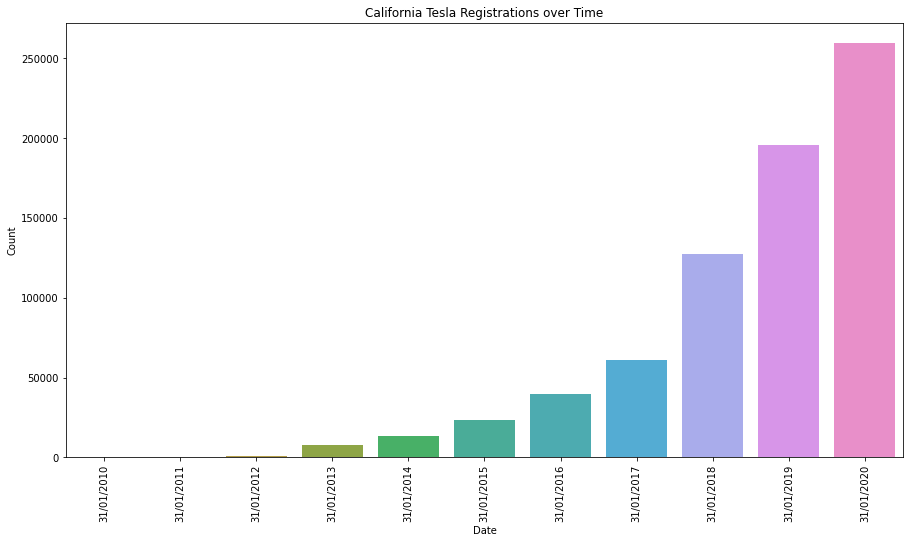

In [213]:
state_reg = grouped_regs[grouped_regs["State"] == "CA"]
state_reg["Datetime"] = pd.to_datetime(state_reg["Date"])
state_reg = state_reg.sort_values(by="Date")
plt.figure(figsize = (15,8))
sns.barplot(y=state_reg.Count, x=state_reg.Date).set_title("California Tesla Registrations over Time")
plt.xticks(rotation=90)
print()

Tesla registrations appear to trend upwards over time. This isn't really surprising, for several reasons. First, Teslas had relatively limited production numbers up until a few years ago, so there were fewer cars available. In addition, Teslas have become more mainstream as the company introduces new models and gains coverage in media.

# Section 2: Analysis

The analytical approaches we used were descriptive modeling and predictive modeling. Specifically, descriptive modeling was used to find a correlation between accidents and Teslas on different highways and interstates. We also took into account the time of day that the accidents occurred to see whether there were other factors that contributed to Tesla accidents. Instead of looking at accidents per state, we decided to investigate the number of accidents per zipcode because there would be a more accurate representation since some states have a larger population than others. We used historical data to see the patterns of US traffic accidents from 2016-2020 as well as EV registration in order to predict if the number of Teslas on the road affects the number of accidents.

We had hypothesized that there would be a negative correlation between the number of highway accidents and the number of Teslas on the road due to their advanced software that prevents accidents. However, the results show that California has the third highest amount of EV registrations, but also the highest number of accidents. We also saw that New York has the largest amount of EV registrations in the country and it is one of the states with the lowest number of accidents. Therefore, we aren't able to see a correlation between the number of accidents and Teslas on the road without taking into account other factors that may lead to these accidents. 

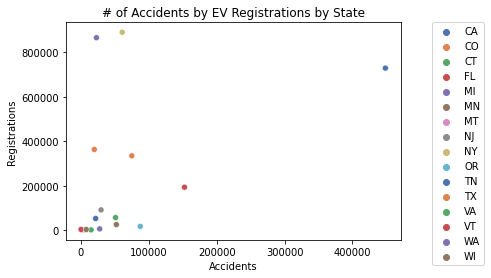

In [214]:
#This scatter plot looks at the correlation between EV registrations and accidents per state.
sns.scatterplot(x="Accidents", y="Registrations", hue="State", palette="deep", data=df_state_accs_regs).set(title="# of Accidents by EV Registrations by State")
plt.legend(bbox_to_anchor=(1.25, 1), loc='upper right', borderaxespad=0)

As we stated above, the number of EV registrations did not have an impact on the number of accidents per state. When looking at states with higher amounts of EV registrations, we see that the number of accidents varied since some states do have less accidents but others do not.

Nevertheless, let's do linear regression on the number of accidents versus Tesla registrations on a state level. We'll load the number of Teslas and number of accidents into a new dataframe, df_state_accs_regs. In doing so, we'll need to perform summation over the grouped registrations / grouped accidents dataframes. We'll then perform ordinary least squares regression.

In [215]:
# Filter accidents dataframe for states in the registrations dataframe
states_in_regs = grouped_regs["State"].unique()
grouped_accs_filtered = grouped_accs
for state in grouped_accs["State"].unique():
    if state not in states_in_regs:
        grouped_accs_filtered = grouped_accs_filtered[grouped_accs_filtered["State"] != state]

# Now, retrieve total counts

df_state_accs_regs = pd.DataFrame(columns = ["State", "Accidents", "Registrations"])

# Get one dataframe with number of accidents and registrations by state
for state in grouped_accs_filtered["State"].unique():
    state_accs = grouped_accs_filtered[grouped_accs_filtered["State"] == state]
    total_accs = int(state_accs["Count"].sum())
    
    state_regs = grouped_regs[grouped_regs["State"] == state]
    total_regs = int(state_regs["Count"].sum())
    
    df_state_accs_regs = df_state_accs_regs.append({"State": state, "Accidents": total_accs, "Registrations": total_regs}, ignore_index = True)
    

Before we run the regression, let's check the plot for registrations versus accidents.

[Text(0.5, 1.0, 'Accidents vs. Tesla Registrations on a State Level')]

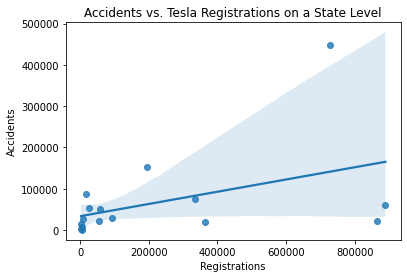

In [216]:
df_state_accs_regs["Accidents"] = pd.to_numeric(df_state_accs_regs["Accidents"])
df_state_accs_regs["Registrations"] = pd.to_numeric(df_state_accs_regs["Registrations"])

# Regression plot
sns.regplot(data = df_state_accs_regs, x = "Registrations", y = "Accidents").set(title="Accidents vs. Tesla Registrations on a State Level")

It seems that there is somewhat of a positive correlation of accidents to registrations of Teslas, through this naive runthrough of linear regression.

It appears that most datapoints are clustered around the lower left of the graph. We'll need to transform our data to pull outliers closer. We'll apply log transformations to both axes.

                            OLS Regression Results                            
Dep. Variable:         AccidentsLog10   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     9.257
Date:                Sat, 12 Mar 2022   Prob (F-statistic):            0.00878
Time:                        18:52:34   Log-Likelihood:                -12.647
No. Observations:                  16   AIC:                             29.29
Df Residuals:                      14   BIC:                             30.84
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.1388      0

C:\Users\miche\anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


[Text(0.5, 1.0, 'Regression on a State Level')]

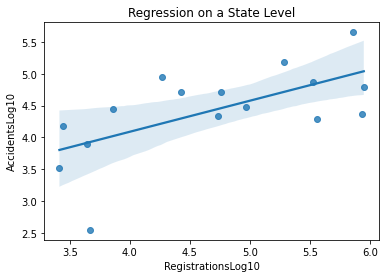

In [217]:
df_state_accs_regs["AccidentsLog10"] = np.log10(df_state_accs_regs["Accidents"] + 0.1)
df_state_accs_regs["RegistrationsLog10"] = np.log10(df_state_accs_regs["Registrations"] + 0.1)

#Linear regression
outcome, predictors = patsy.dmatrices('AccidentsLog10 ~ RegistrationsLog10', df_state_accs_regs)
model = sm.OLS(outcome, predictors)
results = model.fit()
print(results.summary())

# Regression plot
sns.regplot(data = df_state_accs_regs, x = "RegistrationsLog10", y = "AccidentsLog10").set(title="Regression on a State Level")

On a state level, our regression produces a small positive association between registrations and accidents. However, the R-squared value of 0.398 indicates only moderate correlation. Note that our p-value is 0.009, indicating that there is a less than 1% chance that our variables aren't associated. This exceeds the threshold for statistical significance, 0.05. 

However, we want to control for population. Let's do regression for accidents versus vehicle registrations and state population, using US Census Bureau census data from 2019. We'll hard code our population into a new column.

In [218]:
# Hard coded population column
df_state_accs_regs["Population"] = [39512223, 5758736, 3565287, 21477737, 9986857, 5639632, 1068778, 
                                    8882190, 19453561, 4217737, 6829174, 28995881, 8535519, 623989, 7614893, 5822434]

#Linear regression
outcome, predictors = patsy.dmatrices('AccidentsLog10 ~ RegistrationsLog10 + Population', df_state_accs_regs)
model = sm.OLS(outcome, predictors)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         AccidentsLog10   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     8.170
Date:                Sat, 12 Mar 2022   Prob (F-statistic):            0.00504
Time:                        18:52:35   Log-Likelihood:                -10.196
No. Observations:                  16   AIC:                             26.39
Df Residuals:                      13   BIC:                             28.71
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              3.0339      0

C:\Users\miche\anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


When we do multivariate regression with population AND log registrations as predictors, we see a non-significant p-value for registrations (0.281), but a significant p-value for population (0.050). Thus, when we control for population as a confounder, we see that registrations of Teslas is not significantly associated with accident rates.

We'll take a look at registrations versus accidents on a local level. First, we must create a matrix for accidents versus registrations, then apply OLS regression.

In [219]:
# Create lookup table for accidents based on zip codes.
zip_to_accs = accidents_df["Zipcode"].value_counts().to_dict()

df_zip_accs_regs = pd.DataFrame(columns=["Zipcode", "Accidents", "Registrations"])

# For each zip code in registration data, add to final dataframe if it has accidents associated with it.
zip_and_regs = registration_df["Zipcode"].astype(int).value_counts()

# Create dataframe for regression
for zipcode in zip_and_regs.index:
    if zipcode in zip_to_accs:
        new_row = {"Zipcode": zipcode, "Accidents": zip_to_accs[zipcode], "Registrations": zip_and_regs[zipcode]}
        df_zip_accs_regs = df_zip_accs_regs.append(new_row, ignore_index=True)

                            OLS Regression Results                            
Dep. Variable:         AccidentsLog10   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     44.71
Date:                Sat, 12 Mar 2022   Prob (F-statistic):           2.52e-11
Time:                        18:52:42   Log-Likelihood:                -6099.6
No. Observations:                5356   AIC:                         1.220e+04
Df Residuals:                    5354   BIC:                         1.222e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.4007      0

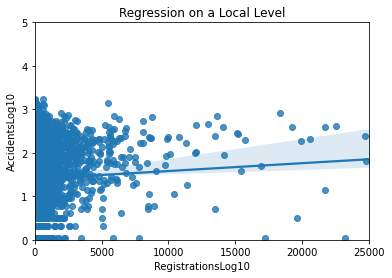

In [220]:
# Convert to numeric values
df_zip_accs_regs["Accidents"] = pd.to_numeric(df_zip_accs_regs["Accidents"])
df_zip_accs_regs["Registrations"] = pd.to_numeric(df_zip_accs_regs["Registrations"])

df_zip_accs_regs["AccidentsLog10"] = np.log10(df_zip_accs_regs["Accidents"] + 0.1)
df_zip_accs_regs["RegistrationsLog10"] = pd.to_numeric(df_zip_accs_regs["Registrations"] + 0.1)

#Linear regression
outcome, predictors = patsy.dmatrices('AccidentsLog10 ~ RegistrationsLog10', df_zip_accs_regs)
model = sm.OLS(outcome, predictors)
results = model.fit()
print(results.summary())

# Generate plot
sns.regplot(data = df_zip_accs_regs, x = "RegistrationsLog10", y = "AccidentsLog10").set(title="Regression on a Local Level")
plt.ylim(0, 5)
plt.xlim(0, 25000)
print()

Note that we have a significant p-value (around 0.000) but a very low correlation (R-squared of 0.008). Our regression line indicates that the log number of accidents increases by 1.808e-05 for each increase in log registrations. In other words, there is a significant association between registrations and accidents on a zip-code level, but the association is almost a flat line. Essentially, the number of accidents stays almost the same regardless of registration level.

# Ethics & Privacy

Privacy: Our data will be coming from government datasets and company financials, which are publicly available and do not contain identifying data. Our registration data, accident data, and population numbers are non-indentifiable and do not pose much privacy risk. When collection data, we'll ensure that our data sources have terms of service which allow for our usage of the data.

There is a bias towards wealth in Tesla owners, and thus a bias towards the number of Teslas based on how wealthy a community is. We thus must limit our interpretation of results to apply to Tesla drivers and not to drivers in general. In terms of the impact of our project, it is possible for our results to be used to advocate for or against driving Teslas. This can impact Tesla's financials, as well as the adoption of EVs/self-driving technology in general. We thus want to analyse and report our conclusions with as much nuance as possible, such that people do not misuse our conclusions.

# Conclusion & Discussion

In this project, we aim to find out if there is a relationship between number of Teslas registered and number of accidents in America. To do so, we retrieved data for vehicle registrations and accidents on a state and local (zip-code) level. We ran ordinary least squares regression on Tesla registrations versus accidents, both with and without controlling for population.

We found that there was a significant positive association between number of Teslas registered and number of vehicle accidents on the state level, but this association disappeared when we ran multivariate regression with state population as a controlled predictor. In other words, we failed to find an association between Tesla registrations and accidents, after removing population as a confounder. We also ran OLS regression for accidents versus registrations on a zip-code level, and found that accidents per zip code was significantly linked with number of Tesla registrations, but the association was very weak with a low correlation.

Our project was very limited by our sources of data. Our data, in general, was not distributed normally and any regression applied will not have very reliable results. Our data sources also are not representative of the entire US, as only a fraction of states had Tesla registration data available. In terms of social impact, we hope that our project starts a conversation about monitoring the effects of new vehicle automation on road safety, even if we could not demonstrate a relationship with our current analysis. Perhaps future projects can control for more variables, pull from more complete data, and examine car models beyond Teslas.

# Team Contributions

Michael: Wrote data cleaning code for accidents dataset, and did preliminary EDA for historical accidents. Michael also did the statistical distribution visualization in the EDA section. In addition, Michael implemented the OLS regression on accidents versus Tesla registrations on state and local (zipcode) levels. Finally, Michael contributed to the written portions of this notebook.
    
Geoffrey: Wrote data cleaning code for Tesla registration datasets, including handling for non-consistent column formatting from source data. In addition, Geoffrey implemented zip-code conversion logic from the Tesla registrations datasets, since some data included county GEO-ID data instead of zipcodes.
    
Carolina: Assisted with research question, provided a dataset involving fatal crashes over 25 years, and contributed to the overview. Carolina also assisted with the analysis. Finally, Carolina cleaned some of the visualizations created by team members.
    
Silvia: Contributed to the overview and assisted with the analysis. Silvia also helped clean some of the visualizations and created a scatter plot regarding EV registrations and accidents by State.